## Makes basic test of the input CatSim catalog, Issue #4

This makes very basic test on the input catalog.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#big enough figures
plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['font.size']= 22
import astropy

In [2]:
#fix fname below to whatever you want it to be
fname="/home/anze/Dropbox/test_80sq_degree_galaxy_catalog.txt"

#circle coordinates, in degress, see issue #3
cent_ra=120
cent_dec=-10
radius=5.16
## since we are working on the fucked up catalog, let's rescale by the fuckup factor
radius*=np.pi/180.

# Cosmology
omega_matter = 0.25
Omega_baryon = 0.045
Omega_curvature = 0
H0 = 73
sigma_8 = 0.9
n_s = 1
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=H0,Om0=omega_matter)

In [3]:
#print fields
print open(fname).readline()

#raJ2000, decJ2000, redshift, u_ab, g_ab, r_ab, i_ab, z_ab, y_ab



In [4]:
# if CSV reader had been a bit less braindead,
# life would be somewhat less painful
# we'll just do it in np
data=np.loadtxt(open(fname),skiprows=0,delimiter=',')
ra=data[:,0]
dec=data[:,1]
redshift=data[:,2]
ugrizy=data[:,3:9]
magr=ugrizy[:,2]

## Total object count

In [5]:
Atest=radius**2*np.pi
Atot=20e3
#total objects per survey
totobj=len(magr)/Atest*Atot
#total objects in gold sample (r<)
totgold=(magr<25.3).sum()/Atest*Atot
print "We are working with:",Atest,"sq deg"
print "If this was a 20k survey, you would have:"
print "Total objects", totobj/1e9, "bil, gold sample",totgold/1e9,"bil"
print "We expect some 4e9 objects in gold sample."
if abs(totgold/4e9-1)>0.1:
    print 'WARNING: weird number of objects in the total sample'

We are working with: 0.0254802691475 sq deg
If this was a 20k survey, you would have:
Total objects 17.2973055131 bil, gold sample 2.92775557307 bil
We expect some 4e9 objects in gold sample.


## redhift and mag histograms

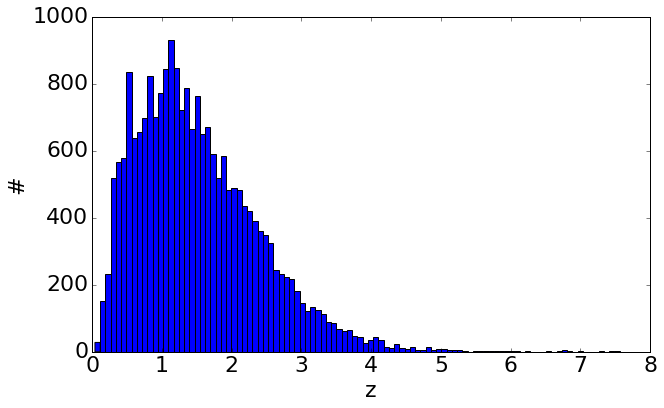

In [6]:
plt.hist(redshift,bins=100)
plt.xlabel('z')
plt.ylabel('#')

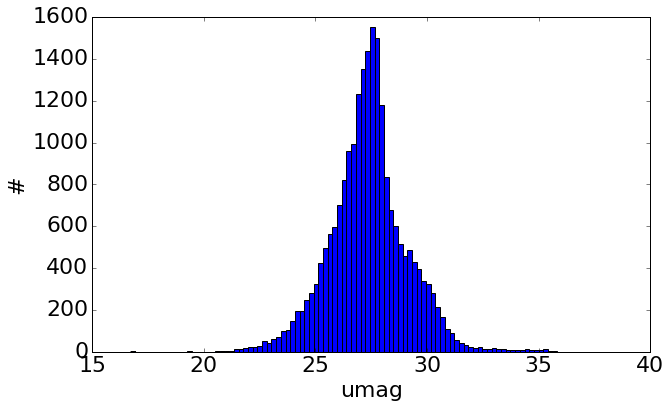

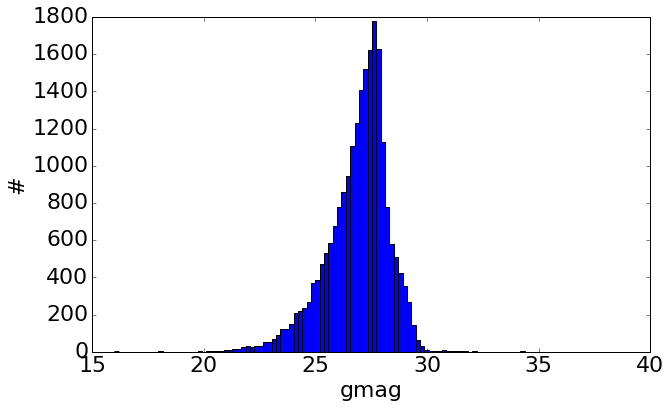

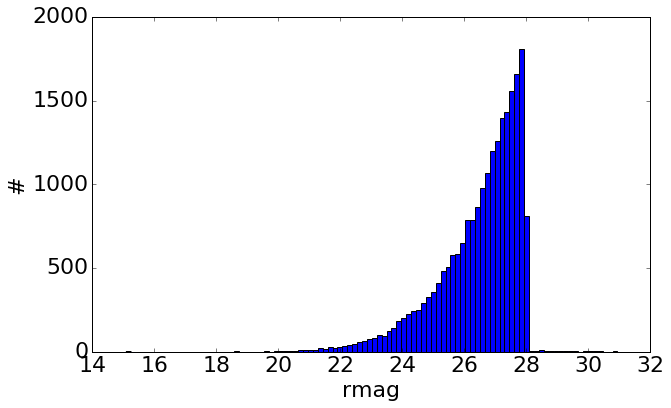

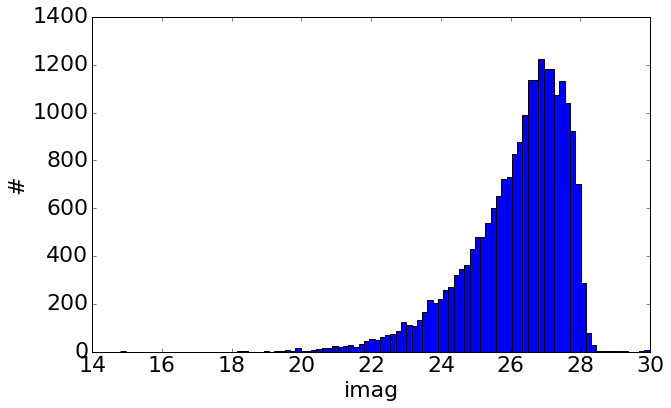

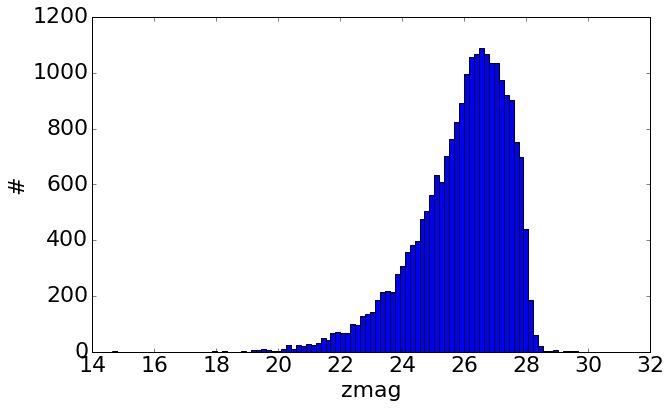

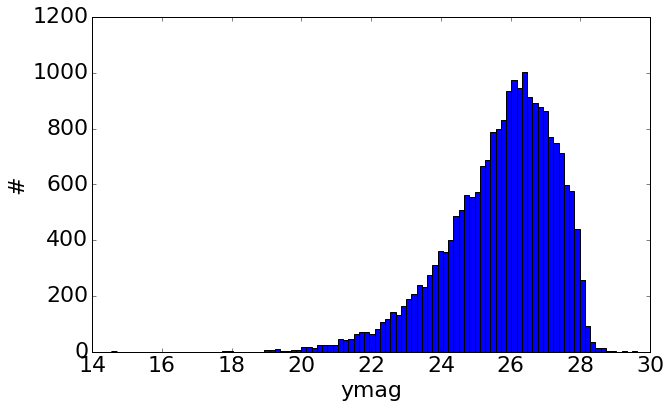

In [7]:
for i,lab in enumerate('ugrizy'):
    plt.figure()
    plt.hist(ugrizy[:,i],bins=100)
    plt.xlabel(lab+"mag")
    plt.ylabel("#")

## generate catalog

In [8]:
print dec.mean(), ra.mean()

-9.99989639243 120.000219966


In [9]:
## generate catalog
rad=cosmo.comoving_distance(redshift)
catx=np.cos(dec/180*np.pi)*np.cos(ra/180*np.pi)
caty=np.cos(dec/180*np.pi)*np.sin(ra/180*np.pi)
catz=np.sin(dec/180*np.pi)
cenx=np.cos(cent_dec/180.*np.pi)*np.cos(cent_ra/180.*np.pi)
ceny=np.cos(cent_dec/180.*np.pi)*np.sin(cent_ra/180.*np.pi)
cenz=np.sin(cent_dec/180.*np.pi)


In [10]:
## first sanity check, distribution of angles wrt to center, in degrees
ang=np.arccos((catx*cenx+caty*ceny+catz*cenz))/np.pi*180

In [11]:
dec.mean(), cent_dec

(-9.9998963924309106, -10)

Max distance: 0.0900412062269 c.f. 0.0900589894029


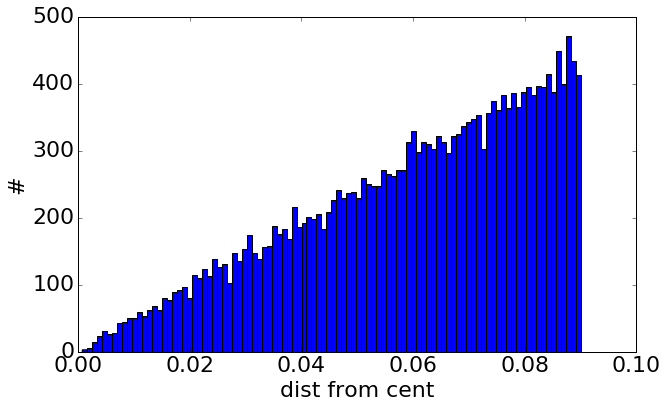

In [12]:
plt.hist(ang,bins=100)
plt.xlabel('dist from cent')
plt.ylabel('#')
print 'Max distance:',ang.max(), "c.f.", radius

In [13]:
## now define an orthonormal system to cenx, ceny, cenz
radvec=[cenx,ceny,cenz]
xortho=np.cross(radvec,[0,0,1])
yortho=np.cross(radvec,xortho)
xortho/=np.sqrt(np.dot(xortho,xortho))
yortho/=np.sqrt(np.dot(yortho,yortho))
print "all zeros:"
print np.dot(xortho,yortho), np.dot(xortho,radvec),np.dot(yortho,radvec)
print "all ones:"
print np.dot(xortho,xortho), np.dot(yortho,yortho)

all zeros:
0.0 0.0 -2.77555756156e-17
all ones:
1.0 1.0


Do you see a nice circle?


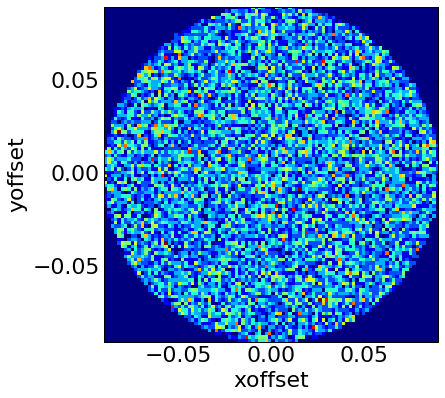

In [14]:
#projected values
xes=np.dot(xortho,[catx,caty,catz])
yes=np.dot(yortho,[catx,caty,catz])
img=np.histogram2d(xes/np.pi*180,yes/np.pi*180,range=[[-radius,radius],[-radius,radius]],bins=100)
plt.imshow(img[0],interpolation='nearest',extent=(-radius,radius,-radius,radius))
plt.xlabel('xoffset')
plt.ylabel('yoffset')
print "Do you see a nice circle?"

# correlation function

Let me clarify that use of correlation function in this sanity check by no means implies that I endorse use for correlation function for any serious analysis except when you have very good reasons to.

In [15]:
import treecorr as tc


In [16]:
# make random catalog.
ranx=np.random.uniform(-radius,radius,len(xes)*10)
rany=np.random.uniform(-radius,radius,len(xes)*10)
choose=np.where((ranx*ranx+rany*rany)<radius**2)
ranx=ranx[choose]
rany=rany[choose]
ranrad=np.array([rad[i].value for i in np.random.randint(len(rad),size=len(ranx))])
ranx*=np.pi/180.
rany*=np.pi/180.


In [17]:
## Let's do analysis in a couple of z-bins
xires=[]
for zmin,zmax in [[0,0.5],[0.5,1.0], [1.0,1.5],[1.5,3.0]]:
    dimin,dimax=cosmo.comoving_distance([zmin,zmax])
    wh=np.where((rad>dimin)&(rad<dimax))
    sigcat=tc.Catalog(x=xes[wh]*rad[wh],y=yes[wh]*rad[wh],z=rad[wh]*np.sqrt(1-xes[wh]**2-yes[wh]**2))
    whr=np.where((ranrad>dimin.value)&(ranrad<dimax.value))
    rancat=tc.Catalog(x=ranx[whr]*ranrad[whr],y=rany[whr]*ranrad[whr],z=ranrad[whr]*np.sqrt(1-ranx[whr]**2-rany[whr]**2))
    dd=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dd.process(sigcat)
    dr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dr.process(sigcat,rancat)
    rr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    rr.process(rancat,rancat)
    xi,xivar=dd.calculateXi(rr,dr)
    xires.append((zmin,zmax,np.exp(dd.logr),xi,xivar))


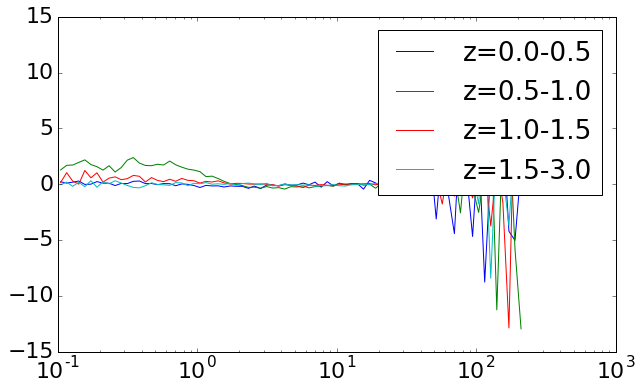

In [18]:
# plot
for zmin,zmax,rr,xi,xivar in xires:
    plt.plot (rr,xi*rr,label="z=%2.1f-%2.1f"%(zmin,zmax)) 
plt.semilogx()
plt.legend()